<a href="https://colab.research.google.com/github/Raanank10/UK_Used_Car_Data/blob/Elad_20210528/Copy_of_100000_UK_Used_Car_Data_set_regression_project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
# General tools
import numpy as np
import scipy as sp
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances

# For the tree visualization
import pydot
from IPython.display import Image, display
from sklearn.externals.six import StringIO

# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse

# For validation
from sklearn.model_selection import train_test_split as split

%matplotlib inline

# Global Parameters:

In [90]:
too_small_population = 30

# Get the Data

In [91]:
url = 'https://raw.githubusercontent.com/Raanank10/UK_Used_Car_Data/main/toyota.csv'

df_Toyota = pd.read_csv(url)
df_Toyota.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [92]:
df_Toyota.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


In [93]:
df_Toyota.shape

(6738, 9)

## Preprocessing - Cleaning

deleting duplicates and row counts under 30. We can`t assume anything based on pole of under 30 cars


In [94]:
unique_Toyota = df_Toyota.drop_duplicates(inplace=False)
unique_Toyota.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6699 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6699 non-null   object 
 1   year          6699 non-null   int64  
 2   price         6699 non-null   int64  
 3   transmission  6699 non-null   object 
 4   mileage       6699 non-null   int64  
 5   fuelType      6699 non-null   object 
 6   tax           6699 non-null   int64  
 7   mpg           6699 non-null   float64
 8   engineSize    6699 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 523.4+ KB


In [95]:
unique_Toyota.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

In [96]:
unique_Toyota.fuelType.value_counts()

Petrol    4058
Hybrid    2040
Diesel     496
Other      105
Name: fuelType, dtype: int64

In [97]:
unique_Toyota.transmission.value_counts()

Manual       3793
Automatic    2651
Semi-Auto     254
Other           1
Name: transmission, dtype: int64

In [98]:
# unique_Toyota.groupby('transmission').filter(lambda x : len(x)>30)
# unique_Toyota.transmission.value_counts()

unique_Toyota = unique_Toyota[unique_Toyota.groupby('transmission')\
                              .transmission.transform('count')>30].copy() 
unique_Toyota.transmission.value_counts()

Manual       3793
Automatic    2651
Semi-Auto     254
Name: transmission, dtype: int64

In [99]:
print(f'remove too_small_population={too_small_population}')
unique_Toyota = unique_Toyota[unique_Toyota.groupby('transmission')\
                              .transmission.transform('count')>too_small_population].copy() 
unique_Toyota.transmission.value_counts()

remove too_small_population=30


Manual       3793
Automatic    2651
Semi-Auto     254
Name: transmission, dtype: int64

In [100]:
unique_Toyota.model.value_counts()

 Yaris            2116
 Aygo             1940
 Auris             709
 C-HR              479
 RAV4              467
 Corolla           265
 Prius             232
 Avensis           114
 Verso             114
 Hilux              85
 GT86               73
 Land Cruiser       51
 PROACE VERSO       15
 Supra              12
 Camry              11
 IQ                  8
 Urban Cruiser       4
 Verso-S             3
Name: model, dtype: int64

In [101]:
print(f'remove too_small_population={too_small_population}')
unique_Toyota = unique_Toyota[unique_Toyota.groupby('model')\
                              .model.transform('count')>too_small_population].copy() 
unique_Toyota.model.value_counts()

remove too_small_population=30


 Yaris           2116
 Aygo            1940
 Auris            709
 C-HR             479
 RAV4             467
 Corolla          265
 Prius            232
 Avensis          114
 Verso            114
 Hilux             85
 GT86              73
 Land Cruiser      51
Name: model, dtype: int64

In [175]:
unique_Toyota.model.unique()

array([' GT86', ' Corolla', ' RAV4', ' Yaris', ' Auris', ' Aygo', ' C-HR',
       ' Prius', ' Avensis', ' Verso', ' Hilux'], dtype=object)

Create new feature called  car _ group: Small, Family, SUV, Sport and Work

In [195]:
#unique_Toyota['car_group'] = 
def car_group_func(row):
    if row['model'] in [' Yaris',' Aygo']:
        return 'Small'
    elif row['model'] in [' Corolla',' Auris']:
        return 'Family'
    elif row['model'] in [' Prius',' Avensis']:
        return 'Family - High End'
    elif row['model'] in [' RAV4',' C-HR']:
        return 'SUV'
    elif row['model'] in [' Hilux',' Verso', ' GT86']:
        return 'Work and Sprot'
    else:
        return row['model'] #'Other'

unique_Toyota['car_group'] = unique_Toyota.apply(car_group_func, axis=1)

In [196]:
unique_Toyota.car_group.value_counts()
# group by:

Small                3978
Family                870
SUV                   810
Family - High End     237
Work and Sprot        166
Name: car_group, dtype: int64

In [102]:
unique_Toyota["car_age"] = 2021 - unique_Toyota["year"]
unique_Toyota.drop('year',axis=1, inplace=True)

In [103]:
unique_Toyota.car_age.value_counts()

4     2015
2     1230
3     1014
5      990
6      521
7      351
8      200
1      124
9       39
10      34
12      26
14      20
13      19
11      18
16      12
15      11
17       7
18       6
19       4
21       1
20       1
22       1
23       1
Name: car_age, dtype: int64

In [104]:
print(f'remove too_small_population={too_small_population}')
unique_Toyota = unique_Toyota[unique_Toyota.groupby('car_age')\
                              .car_age.transform('count')>too_small_population].copy() 
unique_Toyota.car_age.value_counts()

remove too_small_population=30


4     2015
2     1230
3     1014
5      990
6      521
7      351
8      200
1      124
9       39
10      34
Name: car_age, dtype: int64

In [105]:
unique_Toyota.tax.value_counts() 

145    2030
0      1774
135     668
30      571
150     522
20      230
140     221
125     184
260      84
200      67
265      40
160      32
205      26
165      19
10       19
300       9
235       9
325       7
305       2
540       1
240       1
250       1
330       1
Name: tax, dtype: int64

In [106]:
print(f'remove too_small_population={too_small_population}')
unique_Toyota = unique_Toyota[unique_Toyota.groupby('tax')\
                              .tax.transform('count')>too_small_population].copy() 
unique_Toyota.tax.value_counts()

remove too_small_population=30


145    2030
0      1774
135     668
30      571
150     522
20      230
140     221
125     184
260      84
200      67
265      40
160      32
Name: tax, dtype: int64

In [107]:
unique_Toyota.engineSize.value_counts()

1.0    2006
1.5    1413
1.8    1229
1.3     563
2.0     344
1.2     299
2.5     236
1.6     149
2.4      70
1.4      36
2.2      35
2.8      28
3.0       9
0.0       6
Name: engineSize, dtype: int64

In [108]:
print(f'remove too_small_population={too_small_population}')
unique_Toyota = unique_Toyota[unique_Toyota.groupby('engineSize')\
                              .engineSize.transform('count')>too_small_population].copy() 
unique_Toyota.engineSize.value_counts()

remove too_small_population=30


1.0    2006
1.5    1413
1.8    1229
1.3     563
2.0     344
1.2     299
2.5     236
1.6     149
2.4      70
1.4      36
2.2      35
Name: engineSize, dtype: int64

In [109]:
unique_Toyota.mpg.value_counts()

69.0    674
68.9    472
56.5    461
47.9    408
74.3    362
       ... 
51.3      2
83.1      1
37.7      1
6.0       1
50.4      1
Name: mpg, Length: 65, dtype: int64

In [110]:
print(f'remove too_small_population={too_small_population}')
unique_Toyota = unique_Toyota[unique_Toyota.groupby('mpg')\
                              .mpg.transform('count')>too_small_population].copy() 
unique_Toyota.mpg.value_counts()

remove too_small_population=30


69.0    674
68.9    472
56.5    461
47.9    408
74.3    362
58.9    347
58.0    283
78.5    214
72.4    199
67.3    174
57.7    174
76.3    173
55.0    170
78.0    168
86.0    158
60.1    135
57.6    129
47.1    121
55.4    117
70.6    110
67.0    108
85.6     92
65.7     74
39.2     72
94.1     68
52.3     67
36.2     66
43.5     57
49.6     55
41.5     50
62.8     49
80.7     48
76.4     47
66.0     43
61.4     43
51.4     41
40.4     32
Name: mpg, dtype: int64

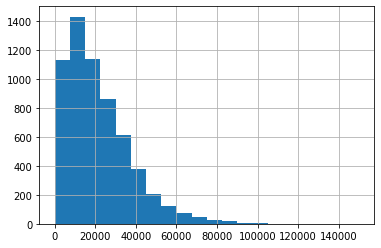

In [169]:
unique_Toyota.mileage.hist(bins=20)

In [112]:
unique_Toyota.describe()

,price,mileage,tax,mpg,engineSize,car_age
count,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000
mean,12057.604026,21469.472859,88.066326,63.990216,1.426382,4.045537
std,5220.098860,16219.306943,70.142050,11.535132,0.396176,1.616511
min,2395.000000,2.000000,0.000000,36.200000,1.000000,1.000000
25%,8295.000000,9500.000000,0.000000,56.500000,1.000000,3.000000
50%,10500.000000,18000.000000,135.000000,67.000000,1.500000,4.000000
75%,14245.000000,29944.000000,145.000000,72.400000,1.800000,5.000000
max,36990.000000,150000.000000,265.000000,94.100000,2.500000,10.000000


## Preprocessing

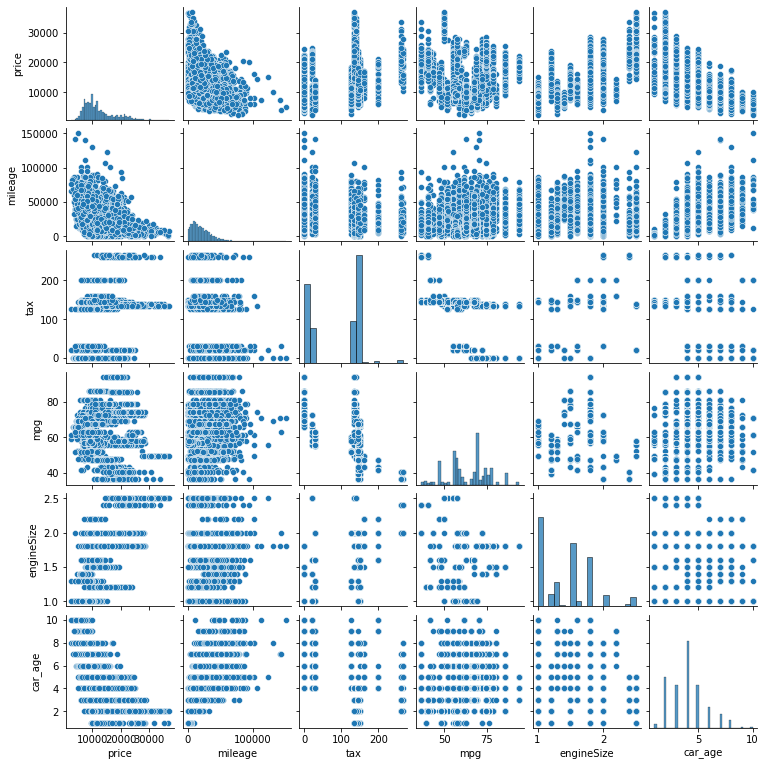

In [197]:
unique_Toyota_num = unique_Toyota.select_dtypes(include=np.number)
sns.pairplot(unique_Toyota_num ,height=1.8)

In [114]:
# unique_Toyota_num = unique_Toyota.select_dtypes(include=np.number)
# sns.pairplot(unique_Toyota_num, hue= 'price' ,height=1.8)

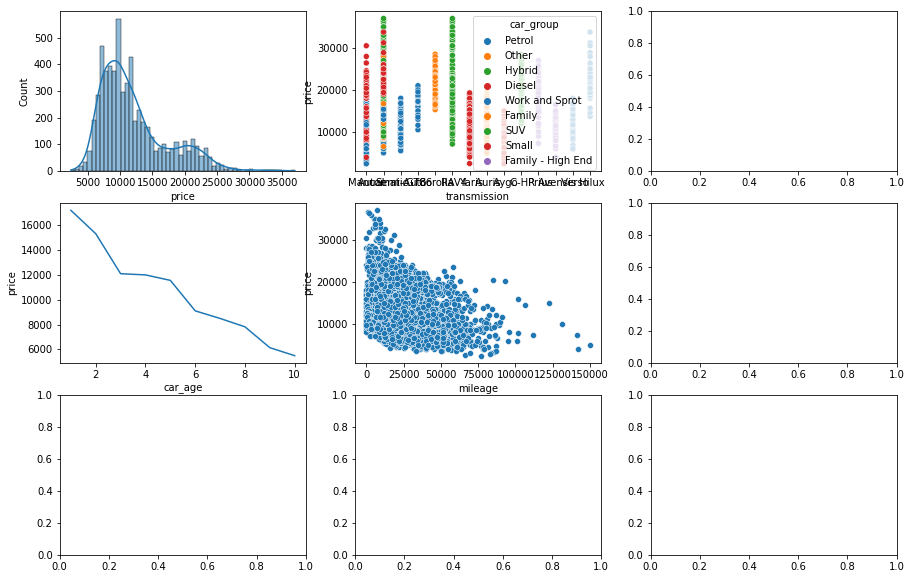

In [200]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
sns.histplot(unique_Toyota.price, kde=True, ax=ax[0,0])
sns.scatterplot(x='transmission',  y='price', data = unique_Toyota, hue='fuelType', ax=ax[0,1])
sns.lineplot(x='car_age', y='price', data = unique_Toyota, ci=None, ax=ax[1,0])
sns.scatterplot(x='mileage', y='price', data = unique_Toyota, ax=ax[1,1]);

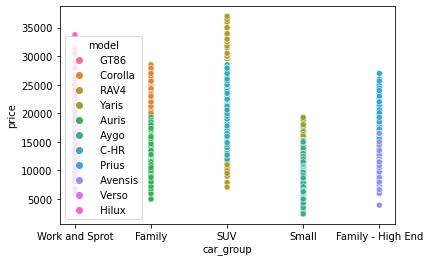

In [212]:
sns.scatterplot(x='car_group',  y='price', data = unique_Toyota, hue='model', legend='brief') #,ax=ax[0,1])

Text(0.5, 1.0, 'Toyota cars by Model')

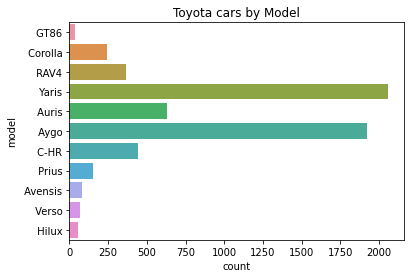

In [116]:
sns.countplot(y = "model", data=unique_Toyota).set_title("Toyota cars by Model")

In [117]:
unique_Toyota.corr()

,price,mileage,tax,mpg,engineSize,car_age
price,1.000000,-0.221875,0.209423,0.015671,0.762581,-0.381670
mileage,-0.221875,1.000000,-0.408858,0.201291,0.185438,0.657436
tax,0.209423,-0.408858,1.000000,-0.488989,0.006717,-0.607804
mpg,0.015671,0.201291,-0.488989,1.000000,0.009951,0.250971
engineSize,0.762581,0.185438,0.006717,0.009951,1.000000,0.029534
car_age,-0.381670,0.657436,-0.607804,0.250971,0.029534,1.000000


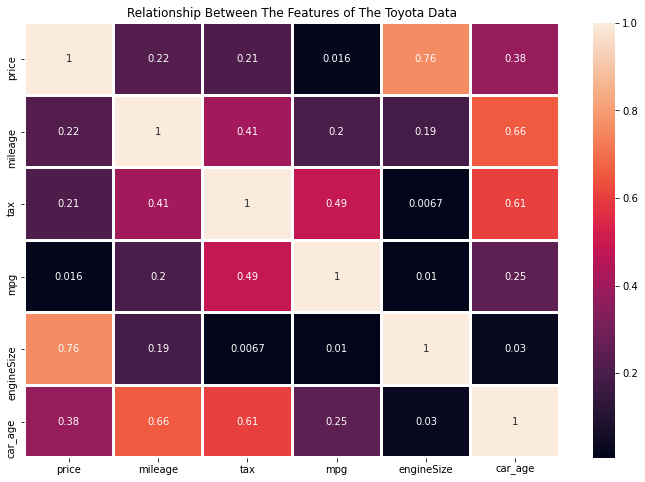

In [118]:
plt.figure(figsize=(12,8))
plt.title("Relationship Between The Features of The Toyota Data")
sns.heatmap(unique_Toyota.corr().abs(), annot=True, linewidths = 2, linecolor = "white")

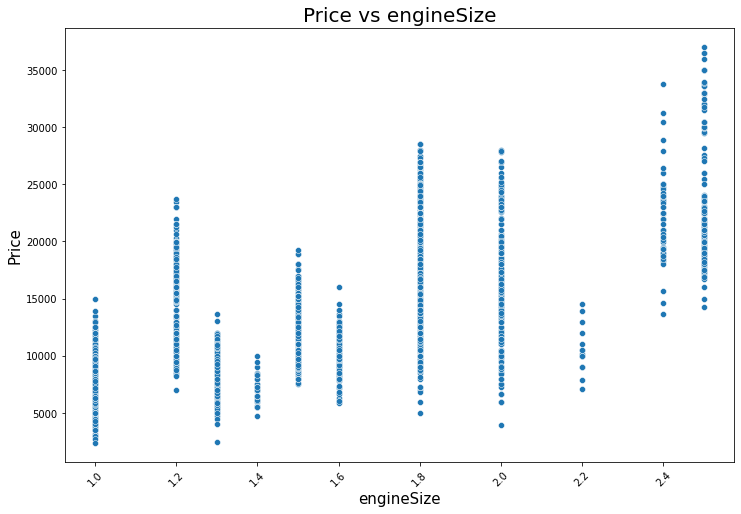

In [119]:
plt.figure(figsize=(12,8))

sns.scatterplot(x= unique_Toyota.engineSize, y = unique_Toyota.price, palette=sns.cubehelix_palette())

plt.xticks(rotation = 45, fontsize = 10)
plt.yticks(fontsize = 10)
plt.ylabel("Price", fontsize = 15)
plt.xlabel("engineSize", fontsize = 15)
plt.title("Price vs engineSize", fontsize = 20)
plt.show()

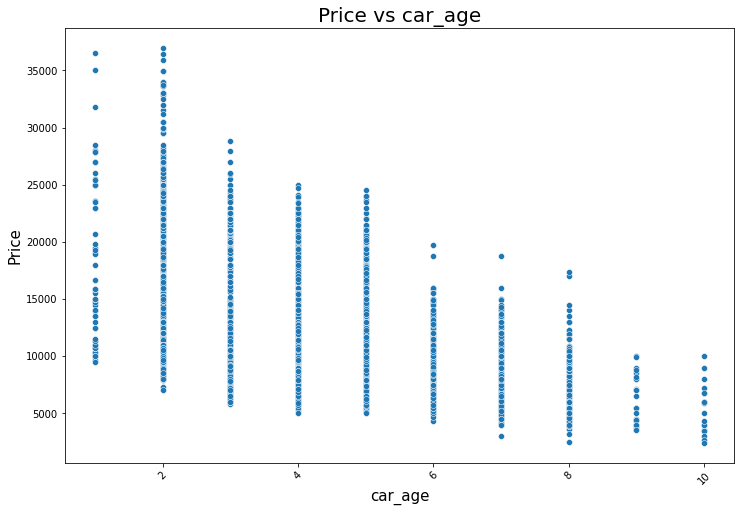

In [120]:
plt.figure(figsize=(12,8))

sns.scatterplot(x= unique_Toyota.car_age, y = unique_Toyota.price, palette=sns.cubehelix_palette())

plt.xticks(rotation = 45, fontsize = 10)
plt.yticks(fontsize = 10)
plt.ylabel("Price", fontsize = 15)
plt.xlabel("car_age", fontsize = 15)
plt.title("Price vs car_age", fontsize = 20)
plt.show()

[Text(0.5, 1.0, 'Mileage per price')]

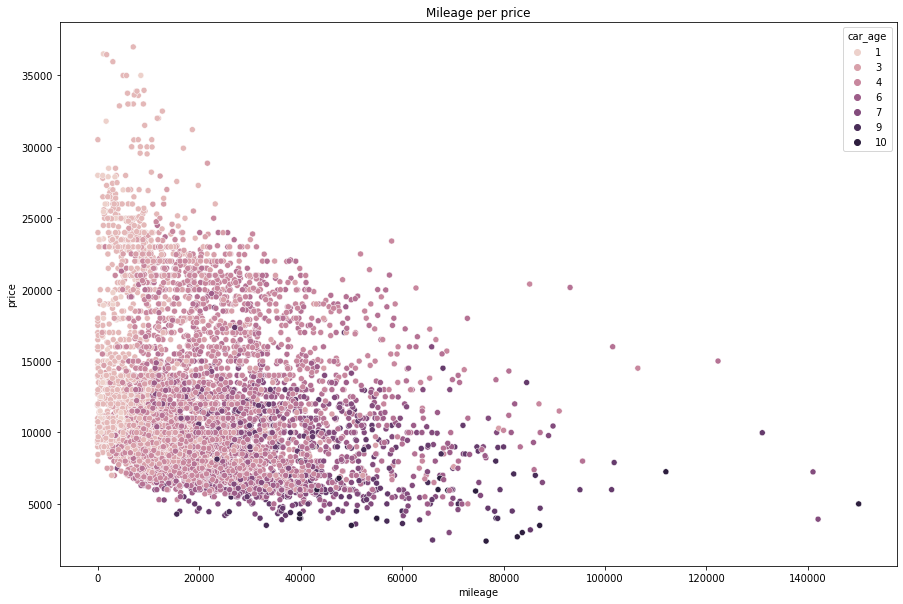

In [121]:
plt.figure(figsize=(15,10)) 
sns.scatterplot(data = unique_Toyota, x= "mileage", y="price", hue = "car_age").set(title = "Mileage per price")

## Data Preparation - Splitting the Data

In [122]:
dummies_Toyota = pd.get_dummies(data = unique_Toyota,columns=["model","transmission","fuelType"])
dummies_Toyota.head()

,price,mileage,tax,mpg,engineSize,car_age,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Corolla,model_ GT86,model_ Hilux,model_ Prius,model_ RAV4,model_ Verso,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,16000,24089,265,36.2,2.0,5,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
1,15995,18615,145,36.2,2.0,4,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,13998,27469,265,36.2,2.0,6,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
3,18998,14736,150,36.2,2.0,4,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
4,17498,36284,145,36.2,2.0,4,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1


In [123]:
X = dummies_Toyota.drop('price', axis=1)
y = dummies_Toyota.price

In [124]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=354455)

In [125]:
X_train.head(10)

,mileage,tax,mpg,engineSize,car_age,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Corolla,model_ GT86,model_ Hilux,model_ Prius,model_ RAV4,model_ Verso,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
4300,3500,145,56.5,1.0,2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
11,12597,145,36.2,2.0,4,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
6435,10136,145,62.8,1.6,4,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
4302,17300,145,68.9,1.0,4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
6564,53830,260,40.4,2.4,4,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
5108,31503,145,68.9,1.0,4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2657,11245,140,76.3,1.5,3,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
1215,9867,145,47.9,1.5,2,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
1294,2000,145,47.9,1.5,2,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
4834,5893,145,67.0,1.0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [126]:
y_train.head(10)

4300    10495
11      17990
6435    15995
4302     8995
6564    18995
5108     8995
2657    14795
1215    11750
1294    12180
4834     8650
Name: price, dtype: int64

In [127]:
dummies_Toyota.describe()

,price,mileage,tax,mpg,engineSize,car_age,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Corolla,model_ GT86,model_ Hilux,model_ Prius,model_ RAV4,model_ Verso,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
count,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000
mean,12057.604026,21469.472859,88.066326,63.990216,1.426382,4.045537,0.103943,0.013694,0.316779,0.073585,0.039597,0.006435,0.009734,0.025408,0.060056,0.011219,0.339548,0.381290,0.589012,0.029698,0.052962,0.309355,0.014024,0.623659
std,5220.098860,16219.306943,70.142050,11.535132,0.396176,1.616511,0.305212,0.116227,0.465259,0.261116,0.195028,0.079964,0.098190,0.157375,0.237610,0.105334,0.473595,0.485744,0.492054,0.169767,0.223975,0.462266,0.117600,0.484507
min,2395.000000,2.000000,0.000000,36.200000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8295.000000,9500.000000,0.000000,56.500000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10500.000000,18000.000000,135.000000,67.000000,1.500000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,14245.000000,29944.000000,145.000000,72.400000,1.800000,5.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,36990.000000,150000.000000,265.000000,94.100000,2.500000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


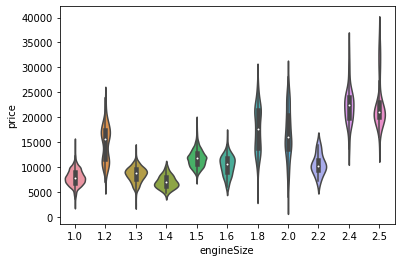

In [128]:
ax = sns.violinplot(x="engineSize", y="price", data=dummies_Toyota)

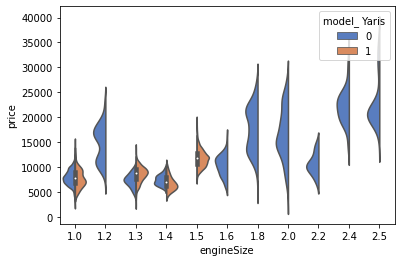

In [129]:
ax = sns.violinplot(x="engineSize", y="price", data=dummies_Toyota , hue="model_ Yaris", palette="muted", split=True)

# Different Models 

##  Linear Regression

### Fitting the Model

In [130]:
lin_model_1 = LinearRegression().fit(X_train, y_train)

In [131]:
list(zip(X_train.columns, lin_model_1.coef_))

[('mileage', -0.05364275948525797),
 ('tax', -2.6676023212263242),
 ('mpg', -37.77450079611846),
 ('engineSize', 3269.234786865738),
 ('car_age', -788.9883348514452),
 ('model_ Auris', -2637.450713604659),
 ('model_ Avensis', -1920.851790366091),
 ('model_ Aygo', -4710.809417002254),
 ('model_ C-HR', 2673.210765512787),
 ('model_ Corolla', 2189.7214350385666),
 ('model_ GT86', 1162.0128660398925),
 ('model_ Hilux', 5294.260532874897),
 ('model_ Prius', 1751.5700167580303),
 ('model_ RAV4', 1819.38668778314),
 ('model_ Verso', -1552.7834466967302),
 ('model_ Yaris', -4068.2669363375876),
 ('transmission_Automatic', 421.0232392502297),
 ('transmission_Manual', -808.3102526133424),
 ('transmission_Semi-Auto', 387.287013363103),
 ('fuelType_Diesel', -1509.7743244221385),
 ('fuelType_Hybrid', 1760.4509702833295),
 ('fuelType_Other', 313.5506669990111),
 ('fuelType_Petrol', -564.2273128602003)]

### Predicting with the Model

In [132]:
y_train_pred = lin_model_1.predict(X_train)

In [133]:
print(y_train_pred, '\n', y_train.values)

[10170.20099531 18013.11557863 12172.29144951 ...  1816.67194814
  8508.99838087 23288.46311688] 
 [10495 17990 15995 ...  3795  7950 20995]


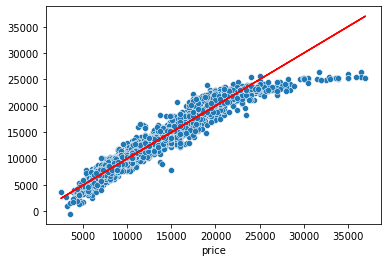

In [134]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [135]:
mse(y_train, y_train_pred)**0.5

1317.0325257647262

## Linear Model for Yaris and Aygo

### Filtering for Yaris Only

In [136]:
model_Yaris = dummies_Toyota.loc[dummies_Toyota['model_ Yaris'] == 1]
model_Yaris.head()

,price,mileage,tax,mpg,engineSize,car_age,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Corolla,model_ GT86,model_ Hilux,model_ Prius,model_ RAV4,model_ Verso,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
813,14000,6821,150,47.9,1.5,2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1
814,10750,14000,145,58.9,1.5,3,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
815,11500,31911,0,78.0,1.5,5,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
816,8500,72053,0,76.3,1.5,7,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
817,8750,32594,150,58.9,1.5,4,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1


In [137]:
X = model_Yaris.drop('price', axis=1)
y = model_Yaris.price

### Spliting the Data



In [138]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=354455)

### Fitting the Model

In [139]:
lin_model_Yaris = LinearRegression().fit(X_train, y_train)

### Predicting with the Model

In [140]:
y_train_pred = lin_model_Yaris.predict(X_train)

### evaluating Yaris the model

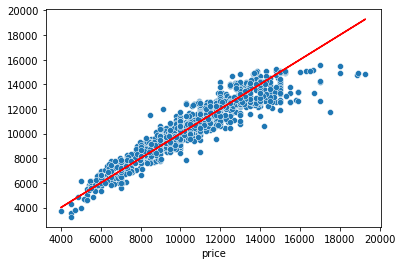

In [141]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [142]:
mse(y_train, y_train_pred)**0.5

818.8846635002676

In [143]:
y_train.describe()

count     1440.000000
mean     10673.772222
std       2293.969343
min       4000.000000
25%       9207.750000
50%      10690.000000
75%      12000.000000
max      19276.000000
Name: price, dtype: float64

In [144]:
y_train.mean()

10673.772222222222

### Remove outlier

In [145]:
model_Yaris.price.mean()

10718.067541302235

In [146]:
model_Yaris.describe()

,price,mileage,tax,mpg,engineSize,car_age,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Corolla,model_ GT86,model_ Hilux,model_ Prius,model_ RAV4,model_ Verso,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
count,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.0,2058.0,2058.0,2058.0,2058.0,2058.0,2058.0,2058.0,2058.0,2058.0,2058.0,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000
mean,10718.067541,20266.863946,85.417881,61.766715,1.426385,4.063654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.364431,0.629252,0.006317,0.010204,0.268707,0.003887,0.717201
std,2305.015680,14777.882067,64.493806,12.113741,0.123231,1.658299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.481387,0.483123,0.079246,0.100523,0.443395,0.062242,0.450469
min,2470.000000,2.000000,0.000000,43.500000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9250.000000,9141.000000,30.000000,55.000000,1.300000,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10758.000000,16987.000000,135.000000,58.000000,1.500000,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,12198.750000,28292.250000,145.000000,76.300000,1.500000,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,19276.000000,87210.000000,160.000000,86.000000,1.500000,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [147]:
q_low = model_Yaris["price"].quantile(0.05)
q_hi  = model_Yaris["price"].quantile(0.95)

print(f'prine mean={model_Yaris.price.mean()}, q_low= {q_low}, q_hi={q_hi}')

model_Yaris_no_outliers = model_Yaris[(model_Yaris["price"] < q_hi) & (model_Yaris["price"] > q_low)]


prine mean=10718.067541302235, q_low= 6669.900000000001, q_hi=14306.09999999999


In [148]:
model_Yaris_no_outliers.describe()
model_Yaris_no_outliers.price.count()

1852

RMSE = 675.426767827335 ,prine mean= 10722.917926565875


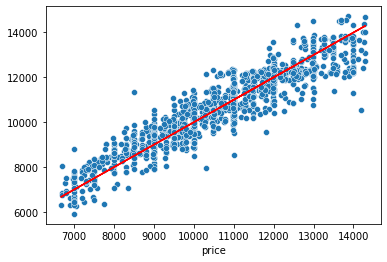

In [149]:
X = model_Yaris_no_outliers.drop('price', axis=1)
y = model_Yaris_no_outliers.price

X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=354455)

lin_model_Yaris_no_outliers = LinearRegression().fit(X_train, y_train)

y_train_pred = lin_model_Yaris_no_outliers.predict(X_train)

print(f'RMSE = {mse(y_train, y_train_pred)**0.5} ,prine mean= {model_Yaris_no_outliers.price.mean()}')

ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

## Trees

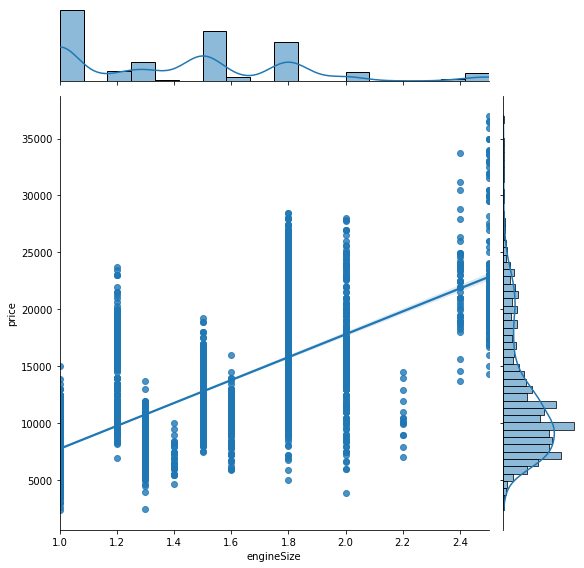

In [150]:
sns.jointplot(x='engineSize', y='price', data=dummies_Toyota, kind='reg', height=8)

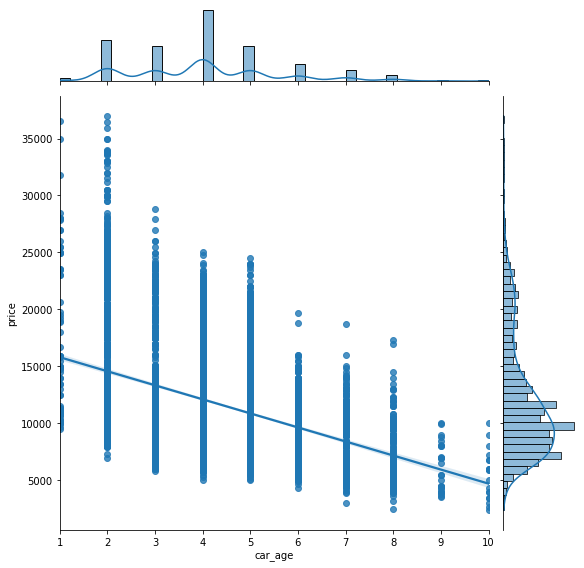

In [151]:
sns.jointplot(x='car_age', y='price', data=dummies_Toyota, kind='reg', height=8)

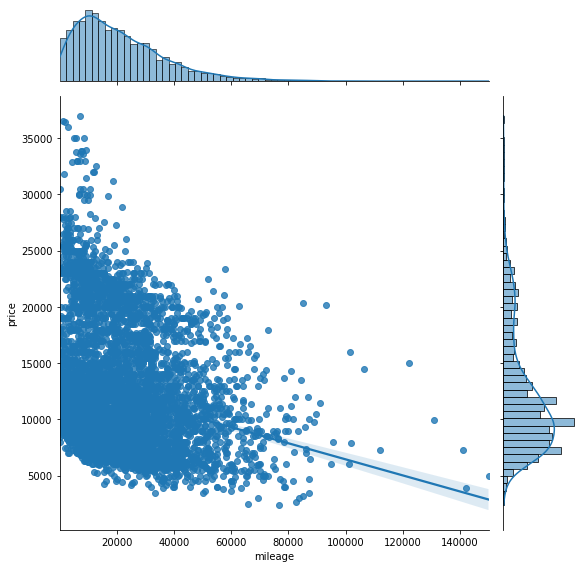

In [152]:
sns.jointplot(x='mileage', y='price', data=dummies_Toyota, kind='reg', height=8)

In [153]:
dummies_Toyota.columns

Index(['price', 'mileage', 'tax', 'mpg', 'engineSize', 'car_age',
       'model_ Auris', 'model_ Avensis', 'model_ Aygo', 'model_ C-HR',
       'model_ Corolla', 'model_ GT86', 'model_ Hilux', 'model_ Prius',
       'model_ RAV4', 'model_ Verso', 'model_ Yaris', 'transmission_Automatic',
       'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel',
       'fuelType_Hybrid', 'fuelType_Other', 'fuelType_Petrol'],
      dtype='object')

### All Models

In [154]:
dummies_Toyota

,price,mileage,tax,mpg,engineSize,car_age,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Corolla,model_ GT86,model_ Hilux,model_ Prius,model_ RAV4,model_ Verso,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,16000,24089,265,36.2,2.0,5,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
1,15995,18615,145,36.2,2.0,4,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,13998,27469,265,36.2,2.0,6,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
3,18998,14736,150,36.2,2.0,4,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
4,17498,36284,145,36.2,2.0,4,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6626,20630,8793,260,36.2,2.4,4,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
6627,19350,20758,260,36.2,2.4,4,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
6628,20388,85141,260,40.4,2.4,4,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
6631,24995,17200,260,36.2,2.4,2,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0


In [155]:
X = dummies_Toyota.drop('price', axis=1)
y = dummies_Toyota.price

In [156]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=354455)

In [157]:
tree_model = DecisionTreeRegressor(max_leaf_nodes=8, min_samples_leaf=0.05)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=8,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.05, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

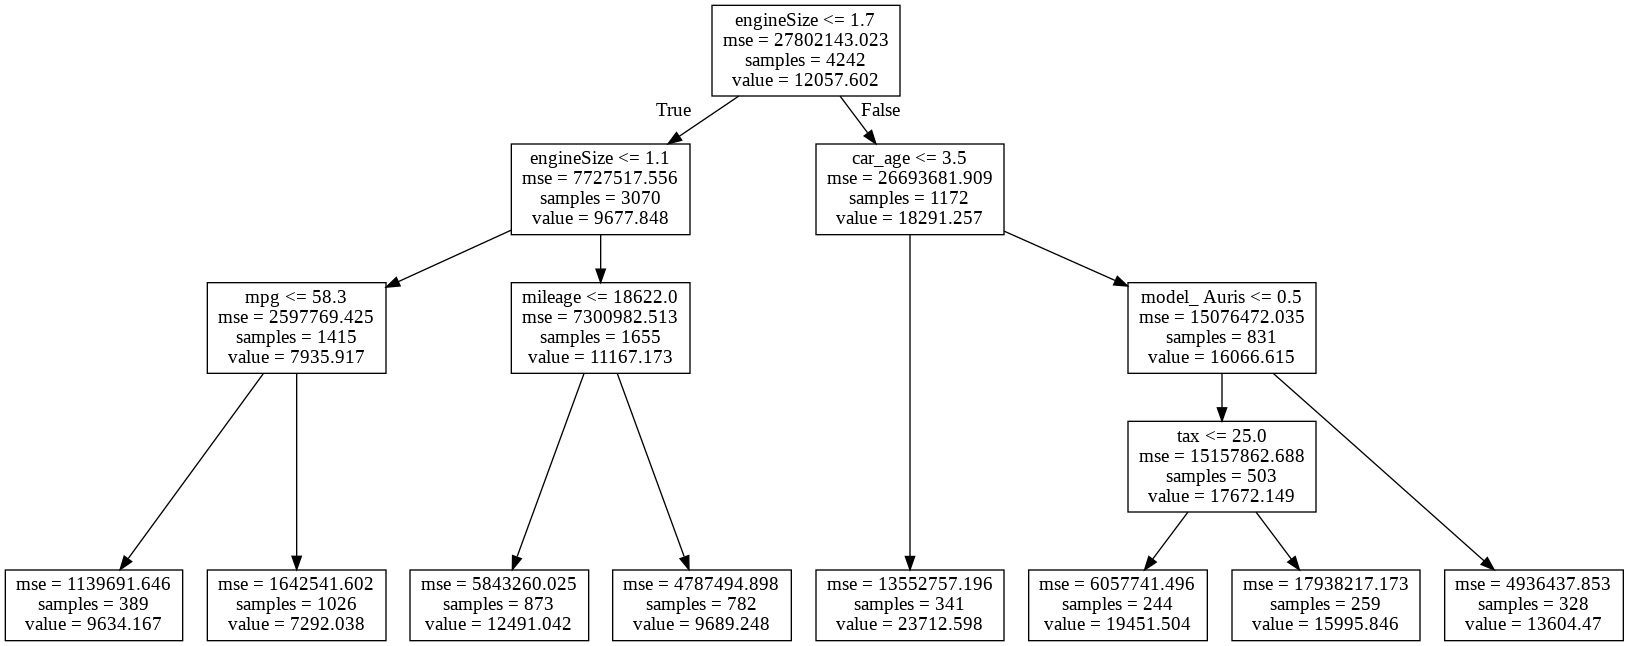

In [158]:
dot_data = StringIO()  
export_graphviz(tree_model, out_file=dot_data, feature_names=X_train.columns, leaves_parallel=True) 
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=750) 

In [159]:
y_train_pred = tree_model.predict(X_train)

In [160]:
# people_rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f'RMSE = {mse(y_train, y_train_pred)**0.5} ,prine mean= {dummies_Toyota.price.mean()}')

RMSE = 2345.574933236782 ,prine mean= 12057.604025738327


In [161]:
for feature, importance in zip(X_train.columns, tree_model.feature_importances_):
    print(f'{feature:12}: {importance}')

mileage     : 0.03423038332623297
tax         : 0.015859866189061066
mpg         : 0.01635605058511106
engineSize  : 0.7494073417562187
car_age     : 0.14942069506831598
model_ Auris: 0.03472566307506006
model_ Avensis: 0.0
model_ Aygo : 0.0
model_ C-HR : 0.0
model_ Corolla: 0.0
model_ GT86 : 0.0
model_ Hilux: 0.0
model_ Prius: 0.0
model_ RAV4 : 0.0
model_ Verso: 0.0
model_ Yaris: 0.0
transmission_Automatic: 0.0
transmission_Manual: 0.0
transmission_Semi-Auto: 0.0
fuelType_Diesel: 0.0
fuelType_Hybrid: 0.0
fuelType_Other: 0.0
fuelType_Petrol: 0.0


### check different values max_leaf_nodes 

5316.280257202408
5096.434405957798


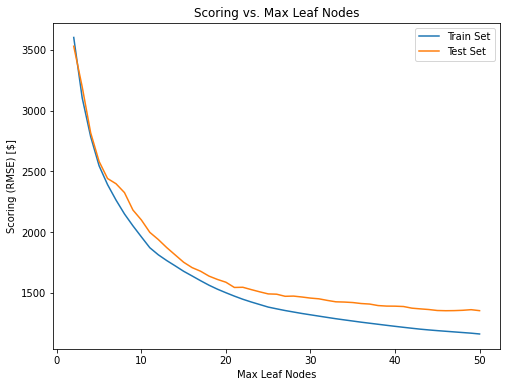

In [162]:
#<! Showing the ability of Decision Trees to Overfit

vMaxLeafNodes = range(2, 51)
XTrain, XTest, yTrain, yTest = split(X_train, y_train, train_size=0.8, random_state=142857)
vTrainRmse = np.zeros(len(vMaxLeafNodes))
vTestRmse = np.zeros(len(vMaxLeafNodes))

#<! This is basically a basic procedure to look after an optimal hyper parameter
for ii in range(len(vMaxLeafNodes)):
  modelTree = DecisionTreeRegressor(max_leaf_nodes=vMaxLeafNodes[ii])
  modelTree.fit(X_train, y_train)
  vTrainRmse[ii] = mse(modelTree.predict(X_train), y_train, squared=False)
  vTestRmse[ii] = mse(modelTree.predict(X_test), y_test, squared=False)

hF, hA = plt.subplots(figsize=(8, 6))
hA.plot(vMaxLeafNodes, vTrainRmse, label='Train Set')
hA.plot(vMaxLeafNodes, vTestRmse, label='Test Set')
hA.set_xlabel('Max Leaf Nodes')
hA.set_ylabel('Scoring (RMSE) [$]')
hA.set_title('Scoring vs. Max Leaf Nodes')
plt.legend()

#<! For Reference (Check against the elementary thing to do - Mean)
print(np.sqrt(np.mean(np.square(yTrain - np.mean(yTrain)))))
print(np.sqrt(np.mean(np.square(yTest - np.mean(yTrain)))))


### Tree for Yaris Only

In [163]:
model_Yaris = dummies_Toyota.loc[dummies_Toyota['model_ Yaris'] == 1]
model_Yaris.head()

,price,mileage,tax,mpg,engineSize,car_age,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Corolla,model_ GT86,model_ Hilux,model_ Prius,model_ RAV4,model_ Verso,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
813,14000,6821,150,47.9,1.5,2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1
814,10750,14000,145,58.9,1.5,3,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
815,11500,31911,0,78.0,1.5,5,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
816,8500,72053,0,76.3,1.5,7,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
817,8750,32594,150,58.9,1.5,4,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1


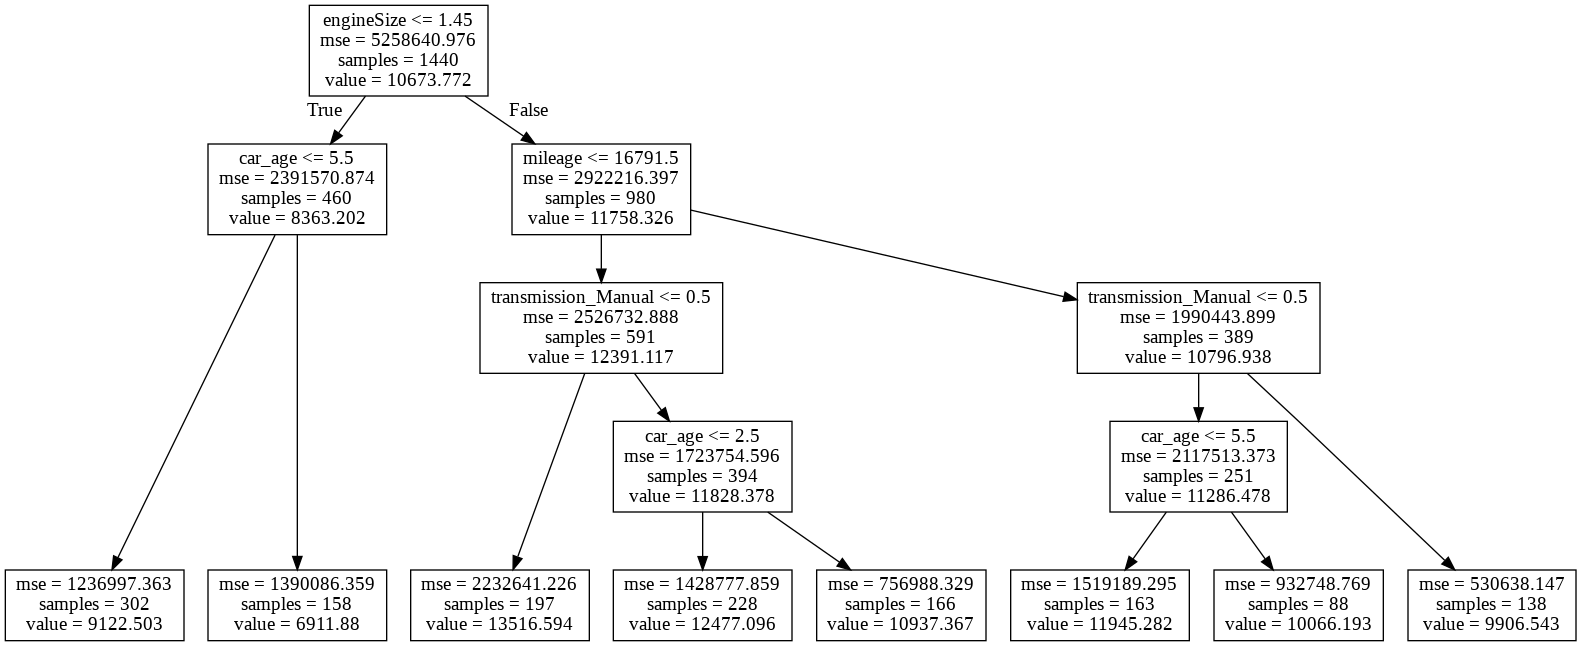

In [164]:
X = model_Yaris.drop('price', axis=1)
y = model_Yaris.price

X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=354455)

tree_model = DecisionTreeRegressor(max_leaf_nodes=8, min_samples_leaf=0.05)
tree_model.fit(X_train, y_train)

y_train_pred = tree_model.predict(X_train)

dot_data = StringIO()  
export_graphviz(tree_model, out_file=dot_data, feature_names=X_train.columns, leaves_parallel=True) 
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=750) 


In [165]:
y_train_pred = tree_model.predict(X_train)

# people_rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f'RMSE = {mse(y_train, y_train_pred)**0.5} ,prine mean= {model_Yaris.price.mean()}')

RMSE = 1144.8545501866236 ,prine mean= 10718.067541302235


### Tree for Yaris no Outlier

In [166]:
q_low = model_Yaris["price"].quantile(0.05)
q_hi  = model_Yaris["price"].quantile(0.95)

print(f'prine mean={model_Yaris.price.mean()}, q_low= {q_low}, q_hi={q_hi}')

model_Yaris_no_outliers = model_Yaris[(model_Yaris["price"] < q_hi) & (model_Yaris["price"] > q_low)]

prine mean=10718.067541302235, q_low= 6669.900000000001, q_hi=14306.09999999999


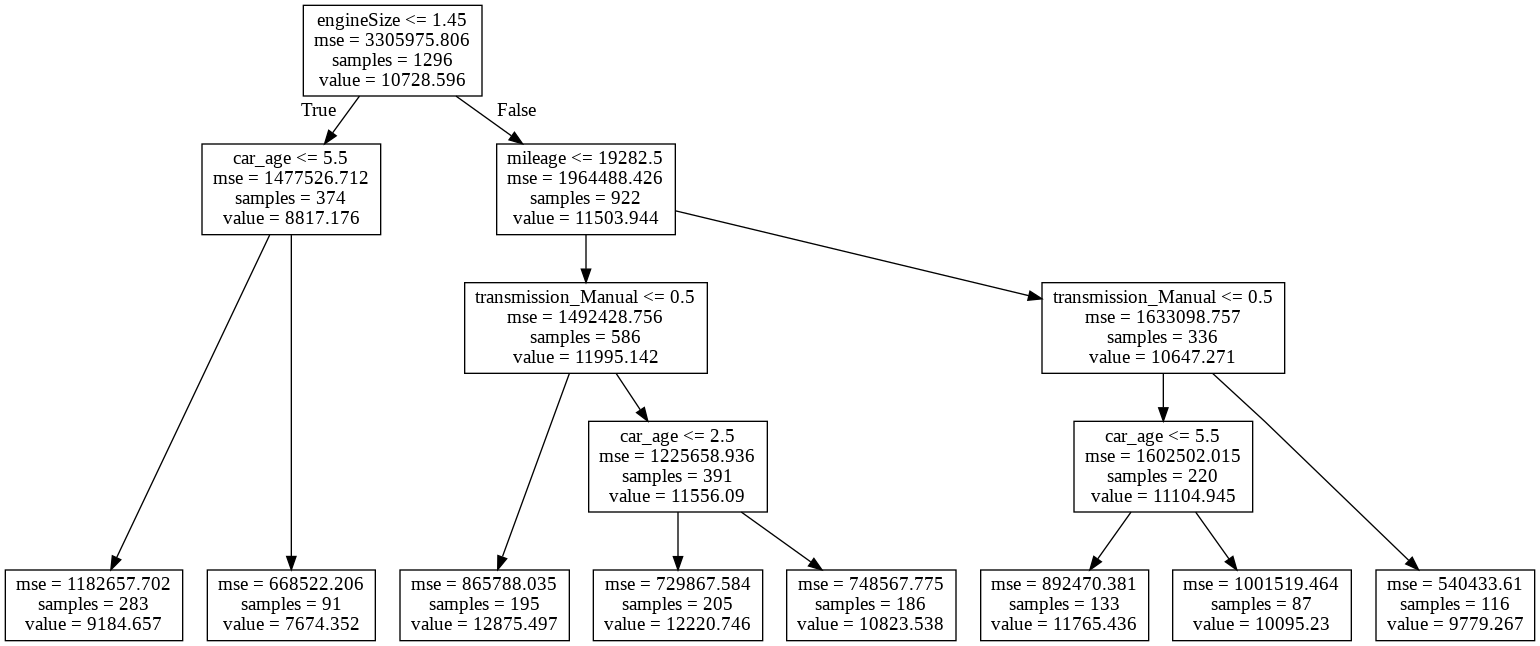

In [167]:
X = model_Yaris_no_outliers.drop('price', axis=1)
y = model_Yaris_no_outliers.price

X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=354455)

tree_model = DecisionTreeRegressor(max_leaf_nodes=8, min_samples_leaf=0.05)
tree_model.fit(X_train, y_train)

y_train_pred = tree_model.predict(X_train)

dot_data = StringIO()  
export_graphviz(tree_model, out_file=dot_data, feature_names=X_train.columns, leaves_parallel=True) 
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=750) 


In [168]:
y_train_pred = tree_model.predict(X_train)

# people_rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f'RMSE = {mse(y_train, y_train_pred)**0.5} ,prine mean= {model_Yaris_no_outliers.price.mean()}')

RMSE = 930.3415305779635 ,prine mean= 10722.917926565875
